# Taxi Prediction and Routing

Authors: Kentaro Hoffman and Benjy Leinwand

Abstract: One advantage that ride sharing services exploit over yellow cabs is coordination between drivers and riders. A central clearing house can match riders and drivers in a particular location, but taxi drivers must individually search for fares based on intuition and experience. The goal of this project is to create a close to real time algorithm dictating where New York City yellow taxi drivers should drive to find fares based on the time and their current location. The optimal decision requires estimating both the demand for taxis in different locations at each time, as well as the time it would take to get from one place to another. We have trained several potential models to estimate these values, and used cross validation to choose our preferred model. Finally, we have tested our preferred model on later data to determine how effective our methodology is in guiding drivers to better choices.   

This project assumes that at the beginning of each hour, data from each taxi is uploaded to a central database, which is then made accessible to each driver. We have restricted our analysis to areas below East 96th St and West 110th St in Manhattan, as yellow cabs do not need to compete with green cabs in this area. This area is broken up into 51 relatively small zones, and we consider all traffic over each hourlong period as our concept of demand.   

Data:

The data comes from NYC's open data Project (https://data.cityofnewyork.us/Transportation/2017-Yellow-Taxi-Trip-Data/biws-g3hs). It was collected in 2017 from Yellow Taxis in NYC, where each row represents a single taxi fare and contains information such as:
* Pickup Date/time
* Pickup Location
* Dropoff Date/time
* Dropoff Location

In addition to other variables which are not relevant for our purposes. First, we keep only trips which begin in 2017 in one of our relevant pick up zones. Then we derive trip duration from pickup and dropoff times.  We clean the data looking for anomalous or nonsensical values, then we group the rows, converting them from individual trips to summary values (counts, sums, or averages) for particular pickup zones, drop off zones(only for the duration dataset), and hour in the year (e.g. 11 pm on November 30th). From here, we are able to begin building our models. 


## Part 1: Predicting Future Ridership and Trip Duration

Our goal in part 1 is to forecast the number of taxi trips taken in each zone for each hour from January 1st 2017 - December 31st 2017. A higher number of taxi trips in the data hopefully represents areas and times with higher demand for taxis (though hypothetically, it could represent where and when the market is already saturated with taxis. Our model as it's currently composed cannot detect locations where there is high demand but no supply, but this is a general GIGO problem). Our goal is to predict current demand, as we only want to determine where an idle taxi should go to best find fares. We need only predict current demand, as after picking up a fare, the taxi may have to drive for a long time to a faraway zone before becoming idle again.  For this purpose, we assume we have all past data up until the previous hour. Though this may not be a currently realistic assumption, it's an achievable goal.

To build our ARIMA and LSTM models, we start by splitting our data into a training set consisting of data from January-October, and testing data consisting of November and December data. Using cross-validation on our October Data, we determine which of our models we believe to be more effective.


## ARIMA
The first step of the ARIMA is to regress the demand for each location and time on the pickup zone, the hour in the day, the day of the week, and the month of the year, as well as all interactions of the last 3 variables. This is necessary as the raw data (see below) breaks the assumption of the ARIMA and need to be preprocessed.
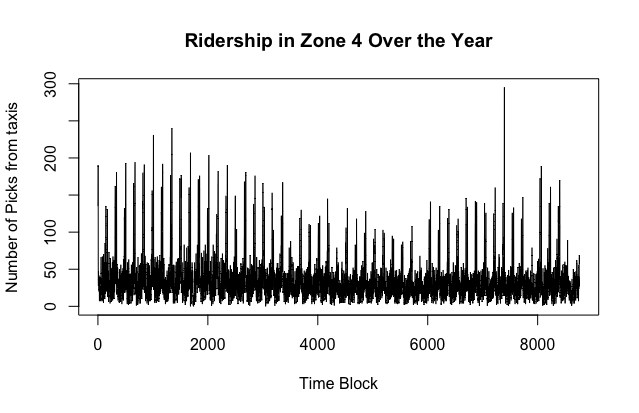

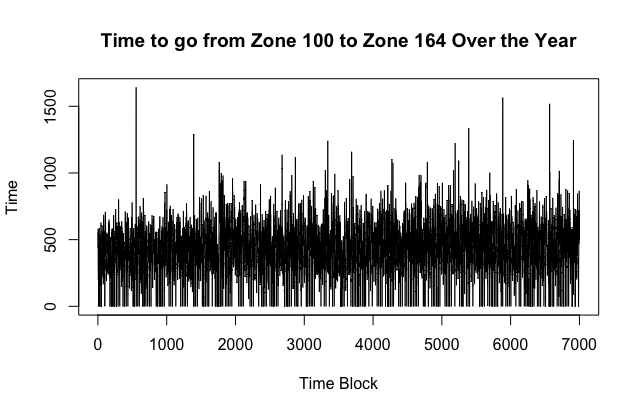

The results of the regression will leave us with residuals that still don't satisfy OLS assumptions (as you can see below for ridership and time), as they have trends over time, potentially reflecting lurking variables we can't observe (e.g. weather), but still look better then before it was preprocessed.

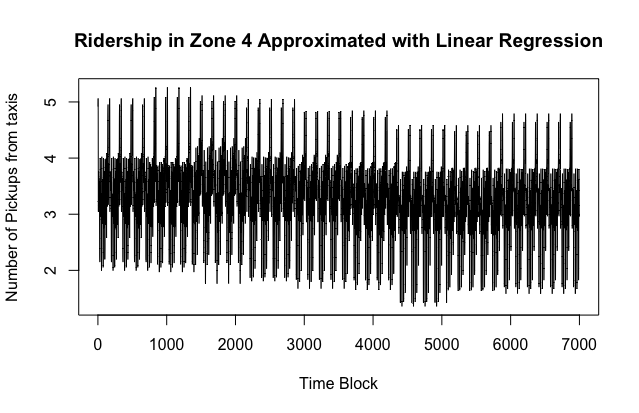
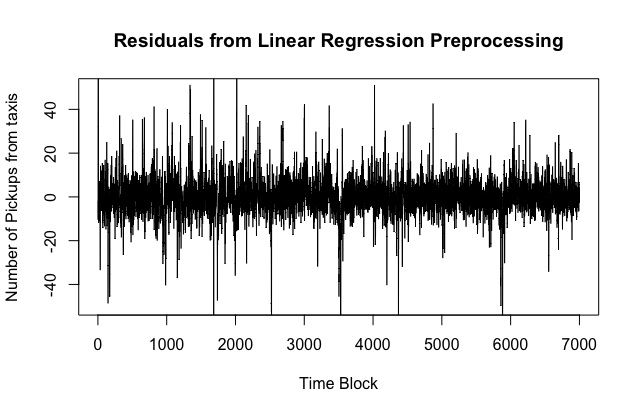

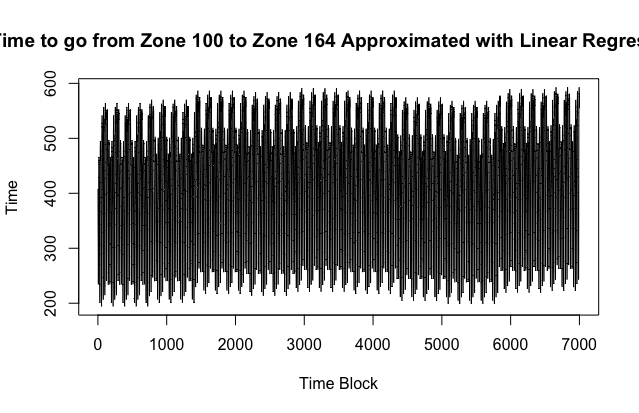
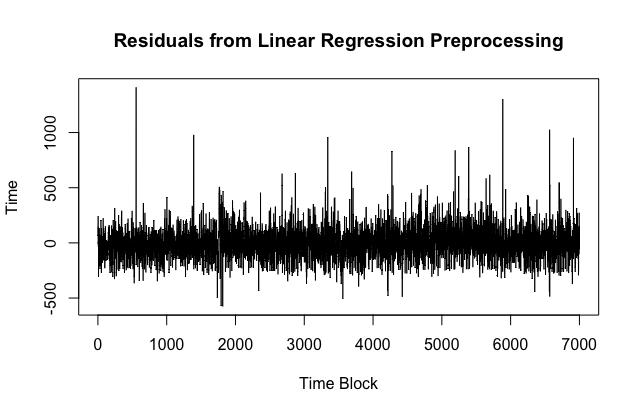


From there, we take the residuals for each zone and create an ARIMA model upon those reisduals. Finally, for our validation(October) or test set(November-December), we use the model fit on the training set (January-September) but continue to predict only the demand and time in the next time step. This mimics the assumption that in real time, we will have data up to the previous hour, so we can use that to predict the current demand. 

The Predictions from the ARIMA look fairly good as well:
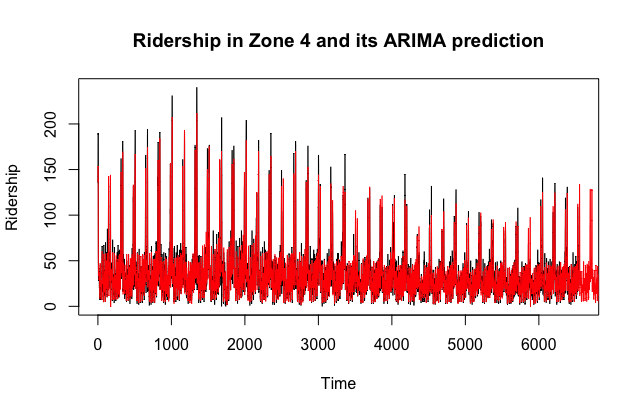

| RMSE on Testing Data over all Zones | MAD(Mean Absolute Deviation) on Testing Data over all Zones  |
|------|------|
|   3649.469  | 101.5886|


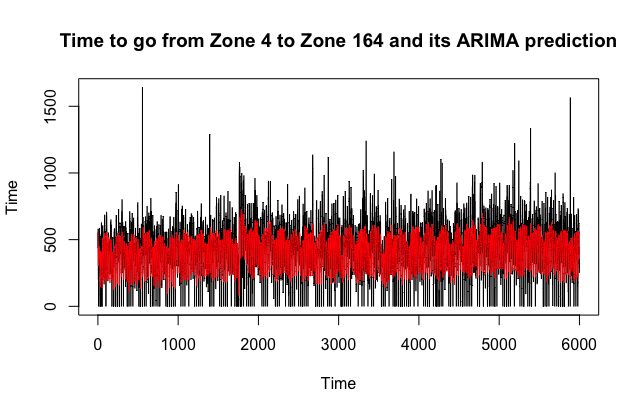

| RMSE on Testing Data over all Zones | MAD(Mean Absolute Deviation) on Testing Data  over all Zones  |
|------|------|
|   3240.812(31.24)  | 94.878|


(For code see Predictive_Model6.R, Predictive_Model7.R, and Plotting.R)


## LSTM

The goal of the LSTM is the same as the ARIMA, predict the ridership and trip duration at the next time step by training on January-September, Validadting on October and testing on November-December. To this end, we created a very simple LSTM in Keras. The architecture takes in one value, the number of riders/ the length of the trip at time step t-1, which gets fed into an LSTM of dept 4, and then outputs one number, its predicted number of riders/ predicted length of trip at time step t.
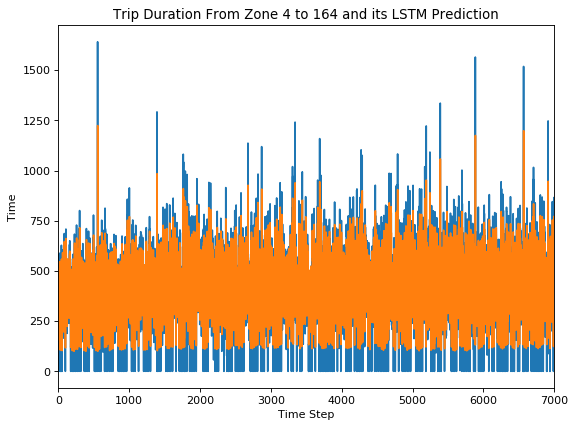

| RMSE on Testing Data over all Zones | MAD(Mean Absolute Deviation) on Testing Data over all Zones  |
|------|------|
|   158.270  | 124.638|

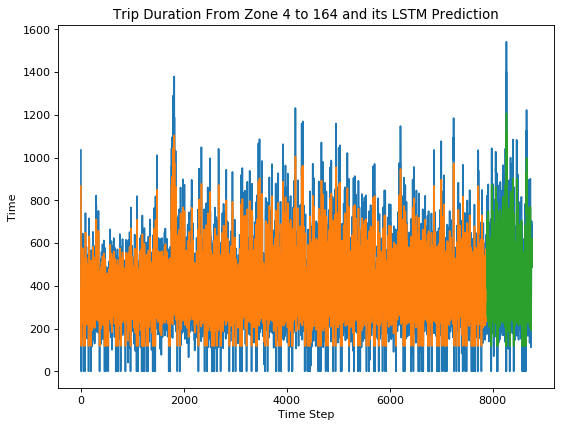

| RMSE on Testing Data over all Zones | MAD(Mean Absolute Deviation) on Testing Data over all Zones  |
|------|------|
|   126.0348  | 91.913|


## Part 2: Predicting Time to Neighboring Zones

Our goal in part 2 is to forecast the time it will take to get from the current location to any neighboring zone at a particular moment in time. We only consider the trips to neighboring zones as one must travel through some neighboring zone to get to any other zone, and we have chosen to greedily move from zone to zone as we expect the driver to take the first available fare, rather than traveling a long distance to a zone with a higher concentration of fares.  No matter what, the driver can only pick up one fare at a time, and that fare may take the driver anywhere, so it makes sense to be greedy. 

This data looks a little bit different than the demand data as we must account for dropoff zone in addition to pickup zone and time, but we need only consider dropoff zones that neighbor the pickup zone. Other than that though, the process is broadly the same. We build similar models to predict trip duration and we use a similar process to test the efficacy of those models. The time frame of the data is the same, and we consider the same zones.    




## Part 3: Combining Demand and Travel Time

Finally, we use the predictions from the models created in parts 1 and 2 to choose the appropriate place to go. 

First, we define the expected value of a neighboring location as the predicted demand (in trips per hour) in that location less the time (in hours) it takes to get to that location multiplied by the predicted demand in the current location. 

$$EV(Neighbor) = \hat{Demand}(Neighbor) - \hat{Duration}(Current \; location, \; Neighbor)*\hat{Demand}(Current \; location)$$

Where $\hat{Duration}(Current \; location, \; Current \; location)$ is always 0. We go to the Neighbor with the greatest expected value. If the current location has the highest expected value, continue to drive around that area. 

Essentially, we'd like to go towards somewhere we expect will have more demand, but there is a cost to leaving the current location, which has some demand also. 

We have predictions and metrics of the results of each individual model, but in addition, we can randomly select times and zones in our test set, and determine how often our prediction of the optimal neighbor matches the true optimal choice of neighbor, where optimality is defined using the criterion above.   
